# Does a vector autogregressive model fit have better behaviour relative to real climate forecasts?

In [1]:
import xarray as xr

import pandas as pd

from src import utils

import matplotlib.pyplot as plt

In [9]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 12

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
DATA_DIR = "../../data/processed"

## Let's just fit to observations for now, though a fit to historical model runs may be more appropriate

In [5]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = (
    utils.calculate_period_AMV_index(
        HadISST["sst"],
        [12, 1, 2, 3],
    )
    .rename("AMV")
    .compute()
)
AMV = utils.round_to_start_of_month(AMV, dim="time")
AMV = utils.get_observation_rolling_mean(AMV, [1, 4, 8])

In [6]:
HadSLP = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = (
    utils.calculate_period_NAO_index(
        HadSLP["slp"],
        [12, 1, 2, 3],
    )
    .rename("NAO")
    .compute()
)
NAO = utils.get_observation_rolling_mean(NAO, [1, 4, 8])

In [7]:
AMV, NAO = xr.align(AMV, NAO)

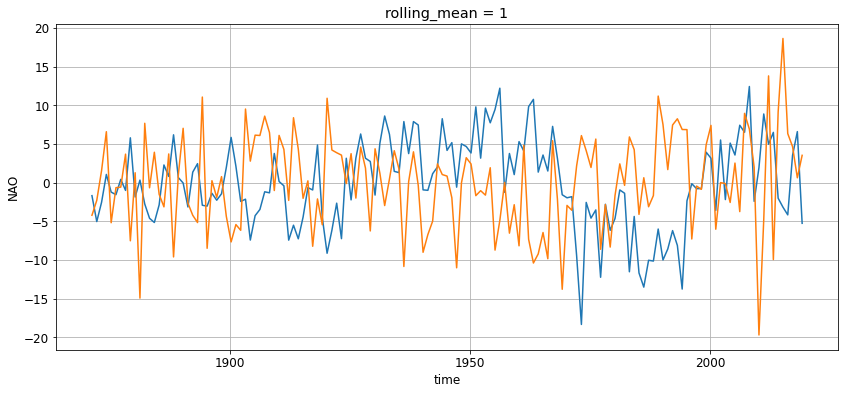

In [10]:
(40 * AMV).sel(rolling_mean=1).plot(label="AMV")
NAO.sel(rolling_mean=1).plot(label="NAO")

plt.grid()

## Fit a VAR model

In [603]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [677]:
AMV_norm = (AMV).sel(rolling_mean=1, drop=True)
NAO_norm = (NAO).sel(rolling_mean=1, drop=True)

input_data = pd.concat(
    (
        AMV_norm.to_dataframe(),
        NAO_norm.to_dataframe(),
    ),
    axis=1,
)

Check that input series are stationary

In [678]:
signif = 0.05

for var in input_data.columns:
    res = adfuller(input_data[var])
    if res[1] < signif:
        print(f"{var} is stationary")
    else:
        print(f"{var} is non-stationary")

AMV is stationary
NAO is stationary


Fit the model

In [679]:
order = 2

model = VAR(input_data)
res = model.fit(order, trend="n")
res.summary()

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 27, Jun, 2022
Time:                     17:00:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.635102
Nobs:                     147.000    HQIC:                 -0.731721
Log likelihood:          -350.526    FPE:                   0.450310
AIC:                    -0.797846    Det(Omega_mle):        0.426768
--------------------------------------------------------------------
Results for equation AMV
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
L1.AMV         0.435933         0.083004            5.252           0.000
L1.NAO        -0.000936         0.001562           -0.599           0.549
L2.AMV         0.258294         0.083413            3.097           0.002
L2.NAO         0

Simulate the process from a random inital condition

In [144]:
import numpy as np

from numpy.lib.stride_tricks import sliding_window_view


def predict(params, scale, inits, n_steps, n_members=1):
    """
    Advance a Vector Autoregressive model forward in time from initial conditions
    by n_steps

    Parameters
    ----------
    params : numpy array
        Array of shape [n_vars*M_lags, n_vars] containing the VAR(n) model
        coefficients as output by
        statsmodels.tsa.api.VAR(data).fit(n_lags, trend="n").params. That is, the
        coefficients along axis 0 should be ordered as
        [ϕ_var1_lag1, ..., ϕ_varN_lag1, ..., ϕ_var1_lagM, ..., ϕ_varN_lagM]
    scale : numpy array
        1D array of length n_vars containing the standard deviation of the noise
        terms in the VAR(n) model as output by
        statsmodels.tsa.api.VAR(data).fit(order, trend="n").resid.std()
    inits : numpy array
        Array containing the initial conditions. Can be 2D or 3D. If 2D, should
        be shape [n_inits, n_vars]. If 3D, should be shape [n_inits, n_samples,
        n_vars], where the final axis contains different samples of initial
        conditions
    n_steps : int
        The number of timesteps to step forward from each initial condition
    """

    def _epsilon(scale, size):
        return np.random.normal(scale=scale, size=size)

    n_params = params.shape[0]
    n_vars = params.shape[1]
    n_lags = int(n_params / n_vars)

    # Some quick checks
    assert len(inits) >= n_lags, (
        f"At least {order} initial conditions must be provided for an "
        f"AR({order}) model"
    )

    # Reorder the params so that they can be easily matmul by the predictors and
    # then appended to predictors to make the next prediction. I.e. reorder from
    # the input order:
    # var1_lag1, ..., varN_lag1, ..., var1_lagM, ..., varN_lagM
    # to:
    # var1_lagM, ..., varN_lagM, ..., var1_lag1, ..., varN_lag1
    sort_params = np.array(
        [range(n_vars * l, n_vars * (l + 1)) for l in range(n_lags - 1, -1, -1)]
    ).flatten()
    params = params[sort_params]

    # Stack the inits as predictors
    inits_lagged = sliding_window_view(inits, window_shape=n_lags, axis=0)
    # Sort predictors so that they are ordered consistently with the reordered
    # params. I.e. reorder from sliding_window_view order:
    # var1_lagM, ..., var1_lag1, ..., varN_lagM, ..., varN_lag1
    # to:
    # var1_lagM, ..., varN_lagM, ..., var1_lag1, ..., varN_lag1
    inits_lagged = np.swapaxes(inits_lagged, -2, -1).reshape(
        (*inits_lagged.shape[:-2], -1), order="C"
    )

    # Loop over lead steps and calculate the prediction
    # Note, the dimensions of res are:
    # [n_members, n_init, n_samples, n_steps * n_vars + n_params]
    res = np.empty(
        (n_members, *inits_lagged.shape[:-1], n_vars * n_steps + n_params),
        dtype="float32",
    )
    res[..., :n_params] = inits_lagged
    for step in range(n_params, n_vars * n_steps + n_params, n_vars):
        fwd = np.matmul(res[..., step - n_params : step], params)

        # Add noise
        fwd += _epsilon(scale, size=fwd.shape)
        res[..., step : step + n_vars] = fwd

    # Drop the first n_params steps, which correspond to the initial conditions
    res = res[..., n_params:]

    # Split into variables
    res = [res[..., i::n_vars] for i in range(n_vars)]

    # Bundle into xarray DataArray for convenience
    dims = ["member", "init", "sample", "lead"]
    names = [f"var{i}" for i in range(len(res))]
    data = {name: (dims, r) for name, r in zip(names, res)}
    return xr.Dataset(
        data,
        coords={
            "member": range(n_members),
            "init": range(n_lags - 1, len(inits)),
            "sample": range(inits.shape[1]),
            "lead": range(1, n_steps + 1),
        },
    )

### Check that your function gives the same results as the `statsmodels` `predict` method

In [680]:
n_times = 100
n_samples = 1

inits = []
for _ in range(n_samples):
    inits.append(res.simulate_var(steps=n_times + order)[order:, ...])
inits = np.stack(inits, axis=1)

In [681]:
res.simulate_var(steps=5, seed=1)

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.26651858,  5.13905656],
       [-0.23165771, 11.12901256],
       [-0.20982775,  5.50982453]])

In [682]:
from statsmodels.tsa.vector_ar.var_model import VARProcess

In [683]:
from statsmodels.tsa.vector_ar import util

# For trend = "n" (see statsmodels/tsa/vector_ar/var_model.py#L1356):
coefs_exog = res.coefs[:0].T
_params_info = {
    "k_trend": 0,
    "k_exog_user": 0,
    "k_ar": order,
}

In [684]:
res.params

,AMV,NAO
L1.AMV,0.435933,-1.676509
L1.NAO,-0.000936,0.062240
L2.AMV,0.258294,-9.742450
L2.NAO,0.000539,-0.012159


In [695]:
res?

Type:            VARResultsWrapper
String form:     <statsmodels.tsa.vector_ar.var_model.VARResultsWrapper object at 0x148e66c7e9e0>
File:            /g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/vector_ar/var_model.py
Docstring:      
Estimate VAR(p) process with fixed number of lags

Parameters
----------
endog : ndarray
endog_lagged : ndarray
params : ndarray
sigma_u : ndarray
lag_order : int
model : VAR model instance
trend : str {'n', 'c', 'ct'}
names : array_like
    List of names of the endogenous variables in order of appearance in
    `endog`.
dates
exog : ndarray

Attributes
----------
params : ndarray (p x K x K)
    Estimated A_i matrices, A_i = coefs[i-1]
dates
endog
endog_lagged
k_ar : int
    Order of VAR process
k_trend : int
model
names
neqs : int
    Number of variables (equations)
nobs : int
n_totobs : int
params : ndarray (Kp + 1) x K
    A_i matrices and intercept in stacked form [int A_1 ...

In [660]:
sig_u = res.sigma_u

In [655]:
VP = VARProcess(
    res.coefs, coefs_exog, res.sigma_u.to_numpy(), _params_info=_params_info
)
VP.simulate_var(steps=5, seed=1)

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-1.93768072,  0.33925494],
       [-1.90191415,  1.60606141],
       [-1.65843271,  0.86220626]])

In [658]:
rs = np.random.RandomState()
rmvnorm = rs.multivariate_normal
# ugen = rmvnorm(np.zeros(len(sig_u)), sig_u, steps*nsimulations).reshape(nsimulations, steps, k)

In [661]:
np.zeros(len(sig_u))

array([0., 0.])

In [663]:
rmvnorm(np.zeros(len(sig_u)), sig_u)

array([0.04507767, 1.73040191])

In [694]:
rmvnorm([0],[1])

ValueError: cov must be 2 dimensional and square

In [215]:
n_steps = 10
sample = 0

my_forecasts = predict(
    res.params.to_numpy(),
    [0, 0],
    inits,
    n_steps=n_steps,
    n_members=1,
).squeeze()

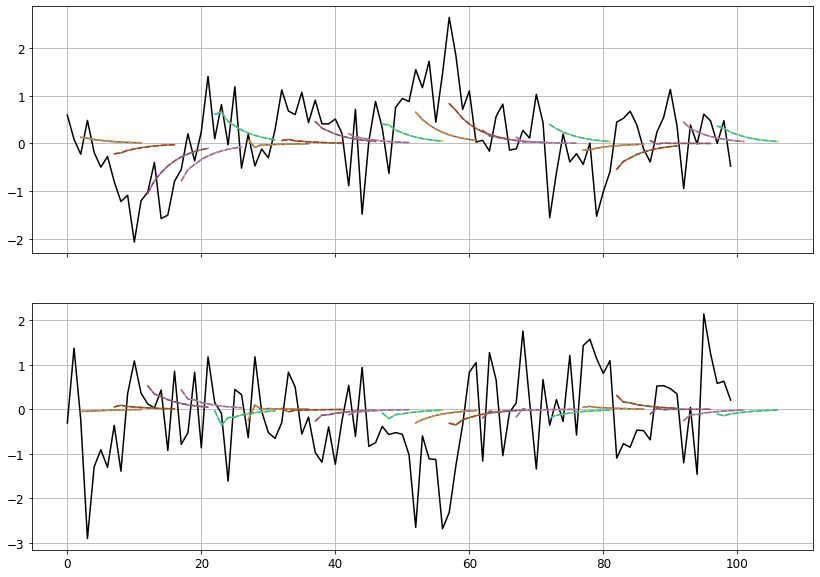

In [216]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(2, 1, sharex=True)

axs[0].plot(inits[:, sample, 0], color="k")
axs[1].plot(inits[:, sample, 1], color="k")

for init in range(1, len(inits), 5):
    my_forecast = my_forecasts.sel(init=init)

    lead = my_forecast.lead + init
    axs[0].plot(lead, my_forecast["var0"])
    axs[1].plot(lead, my_forecast["var1"])

    their_forecast = res.forecast(inits[: (init + 1), sample, :], n_steps)
    axs[0].plot(lead, their_forecast[:, 0], linestyle="--")
    axs[1].plot(lead, their_forecast[:, 1], linestyle="--")

axs[0].grid()
axs[1].grid()

### What do the 8-year means look like?

In [217]:
n_times = 50
n_samples = 1

inits = []
for _ in range(n_samples):
    inits.append(res.simulate_var(steps=n_times + order)[order:, ...])
inits = np.stack(inits, axis=1)

In [218]:
hcst = predict(
    res.params.to_numpy(),
    res.resid.std().to_numpy(),
    inits,
    n_steps=9,
    n_members=169,
).squeeze()

In [222]:
hcst_mean = hcst.sel(lead=slice(2, 9)).mean("lead")

Text(0.5, 1.0, 'AMV')

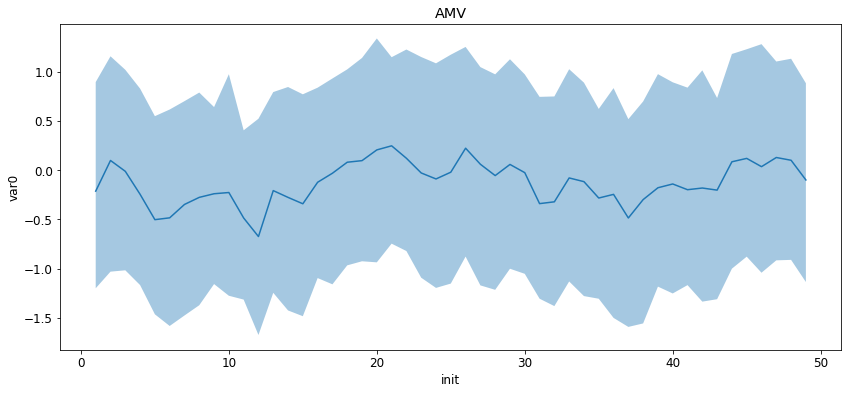

In [226]:
to_plot = hcst_mean["var0"]

plt.fill_between(
    to_plot.init,
    to_plot.quantile(0.05, dim="member"),
    to_plot.quantile(0.95, dim="member"),
    alpha=0.4,
)
to_plot.mean("member").plot()
plt.title("AMV")

Text(0.5, 1.0, 'NAO')

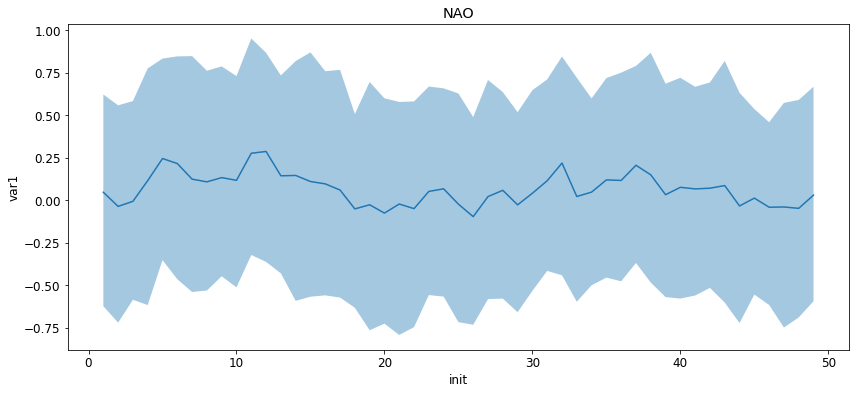

In [227]:
to_plot = hcst_mean["var1"]

plt.fill_between(
    to_plot.init,
    to_plot.quantile(0.05, dim="member"),
    to_plot.quantile(0.95, dim="member"),
    alpha=0.4,
)
to_plot.mean("member").plot()
plt.title("NAO")

### As a check, do the fit myself

In [361]:
order = 2

In [362]:
input_data = pd.concat(
    (AMV.sel(rolling_mean=1, drop=True).to_dataframe(),
    NAO.sel(rolling_mean=1, drop=True).to_dataframe()),
    axis=1
)

In [363]:
def OLS_fit(predictor, response):
    XtX = np.matmul(predictor.T, predictor)
    XtY = np.matmul(predictor.T, response)
    XtX_Inv = np.linalg.inv(XtX)
    
    b = np.matmul(XtX_Inv, XtY)
    
    return b

In [368]:
# Lag order with this approach is [y1_lag2, y1_lag1, y2_lag2, y2_lag1]
predictor = sliding_window_view(input_data.to_numpy(), window_shape=order, axis=0)
predictor = predictor.reshape((predictor.shape[0], -1))[:-1,:]

response = input_data.to_numpy()[order:]

my_params = pd.DataFrame(
    OLS_fit(predictor, response), 
    index = ["L2.AMV", "L1.AMV", "L2.NAO", "L1.NAO"], 
    columns = ['AMV','NAO']
)
my_params

,AMV,NAO
L2.AMV,0.258294,-9.742450
L1.AMV,0.435933,-1.676509
L2.NAO,0.000539,-0.012159
L1.NAO,-0.000936,0.062240


In [369]:
their_params = VAR(input_data).fit(order, trend="n").params
their_params

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AMV,NAO
L1.AMV,0.435933,-1.676509
L1.NAO,-0.000936,0.062240
L2.AMV,0.258294,-9.742450
L2.NAO,0.000539,-0.012159


## Check that `res.sigma2` returned by `statsmodels` is just the variance of the residuals

In [371]:
from statsmodels.tsa.ar_model import AutoReg

res = AutoReg(input_data.to_numpy()[:,0], lags=2,trend="n").fit()

print(f"Square root of res.sigma2: {np.sqrt(res.sigma2)}")
print(f"Standard deviation of residuals: {np.std(res.resid)}")

Square root of res.sigma2: 0.10972550897069776
Standard deviation of residuals: 0.10972513235786074


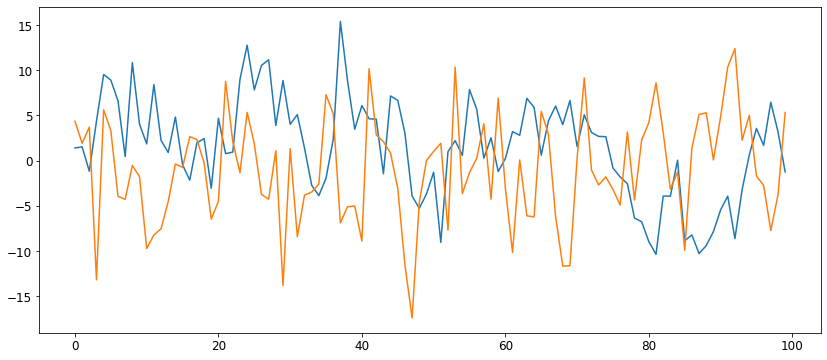

In [167]:
plt.plot((40*init[:,0]))
plt.plot(init[:,1])

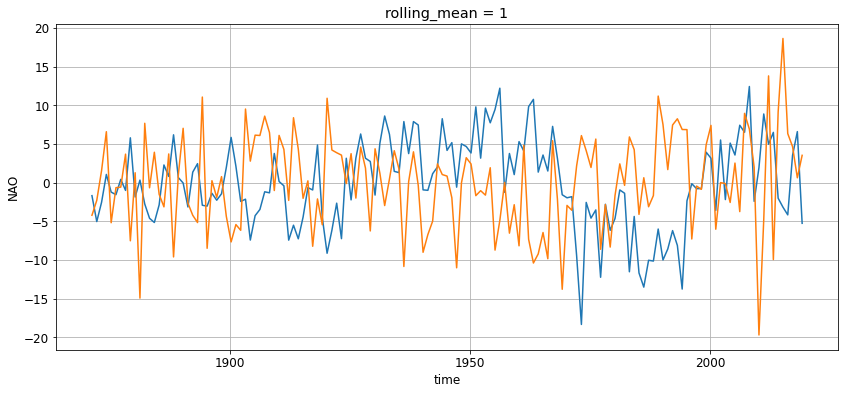

In [153]:
(40*AMV).sel(rolling_mean=1).plot(label="AMV")
NAO.sel(rolling_mean=1).plot(label="NAO")

plt.grid()

### Extending `ar_model` to VAR models

In [229]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [745]:
def fit(
    ds,
    order,
    dim="time",
    kwargs={},
):
    """
    Fit an AR model(s)

    Parameters
    ----------
    ds : xarray Dataset
        The data to fit the (V)AR model to. If multiple variables are available
        in ds, a VAR model is fitted
    order : int or str
        The order of the (V)AR(n) process to fit. For single variable (AR)
        models, users can alternatively pass the string "select_order" to use
        statsmodels.tsa.ar_model.ar_select_order to determine the order.
    dim : str
        The dimension along which to fit the AR model(s)
    kwargs: dict, optional
        kwargs to pass to the relevant statsmodels (sm) method
        - For AR model with order specified: sm.tsa.ar_model.AutoReg
        - For AR model with order="select_order": sm.tsa.ar_model.ar_select_order
        - For VAR model with order specified: sm.tsa.api.VAR
    """
    from statsmodels.tsa.ar_model import AutoReg, ar_select_order
    from statsmodels.tsa.api import VAR

    def _ar_select_order(data, maxlag, kwargs):
        "Wrapper for statsmodels.tsa.ar_model.ar_select_order"
        res = ar_select_order(data, maxlag, **kwargs).model.fit()
        params = np.empty(maxlag + 1)
        params[:] = np.nan
        if res.ar_lags is not None:
            params[[l - 1 for l in res.ar_lags]] = res.params
        params[-1] = res.sigma2
        return params

    def _ar(data, order, kwargs):
        "Wrapper for statsmodels.tsa.ar_model.AutoReg"
        res = AutoReg(data, lags=order, **kwargs).fit()
        return np.concatenate((res.params, [res.sigma2]))

    def _var(*data, order, kwargs):
        "Wrapper for statsmodels.tsa.api.VAR"
        res = VAR(np.column_stack(data)).fit(order, **kwargs)
        params = np.vstack((res.params, res.sigma_u))
        return tuple([params[:, i] for i in range(params.shape[1])])

    if "trend" in kwargs:
        if kwargs["trend"] != "n":
            raise ValueError("The function does not support fitting with a trend")
    else:
        kwargs["trend"] = "n"

    variables = list(ds.data_vars)
    if len(variables) > 1:
        if order == "select_order":
            raise ValueError("Cannot use 'select_order' with a VAR model")
        func = _var
        kwargs = dict(order=order, kwargs=kwargs)
        n_params = len(variables) * order + len(variables)
    else:
        if order == "select_order":
            assert (
                "maxlag" in kwargs
            ), "Must provide maxlag parameter to kwargs when using order='select_order'"

            func = _ar_select_order
            maxlag = kwargs.pop("maxlag")
            kwargs = dict(maxlag=maxlag, kwargs=kwargs)
            n_params = kwargs["maxlag"] + 1
            order = n_params - 1
        else:
            func = _ar
            kwargs = dict(order=order, kwargs=kwargs)
            n_params = order + 1

    data = [ds[v] for v in ds]
    input_core_dims = len(variables) * [[dim]]
    output_core_dims = len(variables) * [["params"]]
    output_dtypes = len(variables) * [float]

    res = xr.apply_ufunc(
        func,
        *data,
        kwargs=kwargs,
        input_core_dims=input_core_dims,
        output_core_dims=output_core_dims,
        vectorize=True,
        dask="parallelized",
        output_dtypes=output_dtypes,
        dask_gufunc_kwargs=dict(output_sizes={"params": n_params}),
    )

    if len(variables) > 1:
        res = xr.merge([r.to_dataset(name=n) for n, r in zip(variables, res)])
    else:
        res = res.to_dataset()

    param_labels = [f"{v}.lag{l}" for l in range(1, order + 1) for v in variables] + [
        f"{v}.noise_var" for v in variables
    ]
    res = res.assign_coords({"params": param_labels}).dropna("params", how="all")
    return res

In [746]:
AMV_input = AMV.to_dataset().sel(rolling_mean=1)
NAO_input = NAO.to_dataset().sel(rolling_mean=1)

input_data = xr.merge((AMV_input, NAO_input))

In [752]:
p = fit(input_data, order=2)

In [753]:
p

<xarray.Dataset>
Dimensions:       (params: 6)
Coordinates:
    rolling_mean  int64 1
  * params        (params) <U13 'AMV.lag1' 'NAO.lag1' ... 'NAO.noise_var'
Data variables:
    AMV           (params) float64 0.4359 -0.0009357 0.2583 ... 0.01234 -0.09165
    NAO           (params) float64 -1.677 0.06224 -9.742 -0.01216 -0.09165 35.27

In [602]:
def generate_samples(
    params, scale, n_times, n_samples, n_members=None, rolling_means=None
):
    """
    Generate random samples from an AR process. Note, the lags of the
    AR params must be consecutive.

    Parameters
    ----------
    params : xarray Dataset
        The (V)AR parameters as output by ar_model.fit()
    n_times : int
        The number of timesteps per sample
    n_samples : int
        The number of samples to generate
    n_members : int, optional
        The number of ensemble members to generate. N ensemble members are
        generated from N predictions initialised from samples of the provided
        process. When provided with rolling_mean, rolling means of length L
        are computed by averaging prediction times 1->L.
    rolling_means : list, optional
        A list of lengths of rolling means to compute
    """
    from statsmodels.tsa.arima_process import ArmaProcess

    if n_members is not None:
        extend = len(params) - 1
    elif rolling_means is None:
        extend = 0
    else:
        extend = max(rolling_means) - 1

    # Generate some AR series
    process = ArmaProcess(np.concatenate(([1], -params)))
    s = process.generate_sample(
        nsample=(n_times + extend, n_samples), scale=scale, axis=0
    ).astype("float32")

    if n_members is None:
        s = xr.DataArray(
            s,
            coords={
                "time": range(1, n_times + extend + 1),
                "sample": range(n_samples),
            },
        )
    else:
        n_leads = 1 if rolling_means is None else max(rolling_means)
        s = predict(
            process.arcoefs,
            s,
            n_leads,
            n_members=n_members,
            scale=scale,
        )
        s = s.rename({"init": "time"})

    if rolling_means is not None:
        if n_members is not None:
            res = [s.sel(lead=1, drop=True).assign_coords({"rolling_mean": 1})]
            for av in rolling_means:
                rm = s.sel(lead=slice(1, av)).mean("lead")
                rm = rm.assign_coords({"rolling_mean": av})
                res.append(rm)
        else:
            res = [s.assign_coords({"rolling_mean": 1})]
            for av in rolling_means:
                rm = (
                    s.rolling({"time": av}, min_periods=av, center=False)
                    .mean()
                    .dropna("time")
                )
                rm = rm.assign_coords({"rolling_mean": av})
                res.append(rm)

        s = xr.concat(res, dim="rolling_mean", join="inner")
    s = s.assign_coords({"time": range(1, s.sizes["time"] + 1)})

    return s.squeeze(drop=True)

In [531]:
variables = ["AMV"]
order = 2

['AMV_1', 'AMV_2', 'std_epsilon']